In [1]:
#Imports
import pandas as pd
import numpy as np
import re
import string

# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
!pip install langdetect
from langdetect import detect
from time import time
from tqdm import tqdm
!pip install altair
import altair as alt
!pip install nltk
import nltk 
!pip install wordcloud
import wordcloud 
from nltk import pos_tag #only supports pos tagging for english
import random
from nltk.tokenize import word_tokenize #this is not robust for other languages except english
from string import punctuation
from nltk.tokenize import sent_tokenize

import timeit

Looking in indexes: http://repository.rnd.amadeus.net/repository/api/pypi/pypi/simple
Looking in indexes: http://repository.rnd.amadeus.net/repository/api/pypi/pypi/simple
    100% |████████████████████████████████| 737kB 10.1MB/s ta 0:00:01
Looking in indexes: http://repository.rnd.amadeus.net/repository/api/pypi/pypi/simple
    100% |████████████████████████████████| 1.5MB 79.1MB/s ta 0:00:011
    100% |████████████████████████████████| 307kB 2.4MB/s ta 0:00:011
    100% |████████████████████████████████| 665kB 2.5MB/s ta 0:00:0111
Looking in indexes: http://repository.rnd.amadeus.net/repository/api/pypi/pypi/simple
    100% |████████████████████████████████| 368kB 94.9MB/s eta 0:00:01


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from multiprocessing import  Pool
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [6]:
all_df = pd.read_csv("reviews_joined_with_lang.csv")
#Replace the nan values because string and np.nan are not compatible
all_df = all_df.drop(['Unnamed: 0'], axis=1)
# print(all_df.head(1))
all_df['language'] = all_df['language'].fillna('NA')
print(all_df.columns)
all_df.describe()

Index(['title', 'text', 'date_stayed', 'offering_id', 'num_helpful_votes',
       'date', 'review_id', 'via_mobile', 'ratings_service',
       'ratings_cleanliness', 'ratings_overall', 'ratings_value',
       'ratings_location', 'ratings_sleep_quality', 'ratings_rooms',
       'author_username', 'author_num_cities', 'author_num_helpful_votes',
       'author_num_reviews', 'author_num_type_reviews', 'author_id',
       'author_location', 'ratings_check_in_front_desk',
       'ratings_business_service_(e_g_internet_access)', 'hotel_class',
       'hotel_region_id', 'hotel_url', 'hotel_phone', 'hotel_details',
       'hotel_type', 'hotel_name', 'hotel_address_region',
       'hotel_address_street_address', 'hotel_address_postal_code',
       'hotel_address_locality', 'language'],
      dtype='object')


,offering_id,num_helpful_votes,review_id,ratings_service,ratings_cleanliness,ratings_overall,ratings_value,ratings_location,ratings_sleep_quality,ratings_rooms,author_num_cities,author_num_helpful_votes,author_num_reviews,author_num_type_reviews,ratings_check_in_front_desk,ratings_business_service_(e_g_internet_access),hotel_class,hotel_region_id,hotel_phone,hotel_details
count,8.785610e+05,878561.000000,8.785610e+05,760918.000000,759835.000000,878561.000000,753695.000000,664904.000000,500903.000000,705404.000000,613968.000000,653980.000000,801438.000000,515610.000000,99784.000000,65729.000000,843624.000000,878561.000000,0.0,0.0
mean,3.058972e+05,1.153104,8.633481e+07,4.069742,4.208512,3.936228,3.896310,4.415007,4.114891,3.921873,12.853202,20.727658,17.629102,14.302696,3.931993,3.641711,3.465306,52742.420843,NaN,NaN
std,4.388314e+05,2.898120,4.999254e+07,1.179085,1.075466,1.165074,1.179857,0.889482,1.112003,1.149181,14.702529,40.328408,28.973244,17.163277,1.221558,1.244268,0.743663,12264.535506,NaN,NaN
min,7.257200e+04,0.000000,2.243990e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,28970.000000,NaN,NaN
25%,8.999800e+04,0.000000,3.488850e+07,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,2.000000,5.000000,3.000000,3.000000,3.000000,35805.000000,NaN,NaN
50%,1.114080e+05,0.000000,1.113905e+08,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,8.000000,8.000000,8.000000,9.000000,4.000000,4.000000,3.500000,60745.000000,NaN,NaN
75%,2.416400e+05,1.000000,1.283089e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,16.000000,22.000000,22.000000,17.000000,5.000000,5.000000,4.000000,60763.000000,NaN,NaN
max,3.574675e+06,515.000000,1.478017e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,284.000000,964.000000,935.000000,330.000000,5.000000,5.000000,5.000000,60956.000000,NaN,NaN


In [7]:
test_df = all_df[all_df.language == 'en'].sample(100000)[['offering_id', 'review_id', 'text', ]]

In [15]:
sentences = []
for t in tqdm(test_df.text):
    sentences.append(tokenize_in_sentences(t))

100%|██████████| 100000/100000 [00:30<00:00, 3263.58it/s]


In [16]:
test_df["sentences"] = sentences

In [19]:
test_df.to_csv("trip_advisor_english_for_testing.csv")

In [ ]:
%%timeit
all_df.text.apply(lambda x: x.lower())
# test()

In [6]:
import time
def lower(df):
    df = df.copy()
    df.text = df.text.apply(lambda x: time.sleep(0.0001))
    return df


In [ ]:
tic = time.time()
lower(all_df)
tac = time.time()
print(tac - tic)

In [ ]:
tic = time.time()
parallelize_dataframe(all_df, lower, n_cores=8)
tac = time.time()
print(tac - tic)

In [7]:
#Total number of reviews
print("Total number of reviews: ", len(all_df))

Total number of reviews:  878561


In [8]:
#Total number of Hotels
print("Total number of hotels: ", len(all_df.offering_id.unique()))

Total number of hotels:  3945


In [9]:
def random_color():
    colors = "bgrcmyk"
    i = random.randint(0,6)
    return colors[i]

In [10]:
def sort_two_lists(A,B, reverse=False):
    """sorts the lists A and B parallely in accordance with A"""
    my_dict = {}
    for k, v in zip(A,B):
        my_dict[k] = v
    A.sort(reverse=reverse)
    B = []
    for k in A:
        B.append(my_dict[k])
    return A,B
#Test the above function
# A = [2,3,1]
# B = ["b","c","a"]
# sort_two_lists(A,B, reverse=True)

In [11]:
def filter_two_lists(A, B, my_func):
    """Filter lists A and B if my_func returns True for elements on A"""
    my_dict = {}
    for k, v in zip(A,B):
        my_dict[k] = v
    A = [i for i in A if my_func(i)]
    B = []
    for k in A:
        B.append(my_dict[k])
    return A, B
#Test for this function
# A = [1,2,3,4,5]
# B = [-1,-2,-3,-4,-5]
# filter_two_lists(A,B, lambda x: x>2)

In [12]:
#Function to filter lists by quantile
def filter_by_quantiles(X, q):
    """Filters X using quantiles q"""
    assert(len(q) == 2)
    q.sort()
    lb, ub = np.quantile(X, q)
    X = [x for x in X if x > lb and x < ub]
    return X
#test the above function
# X = range(1,1000,1)
# filter_by_quantiles(X, [0.71,0.72])

In [90]:
def tokenize_in_words(text, lower_case = False):
    if lower_case:
        text = text.lower()
    result = word_tokenize(text) 
    for elem in result:
        if elem in punctuation:
            result.remove(elem)
    return result

#test the above function
text = "Hi there! Je m'appele äkash, akash über."
tokenize_in_words(text)
    

['Hi', 'there', 'Je', "m'appele", 'äkash', 'akash', 'über']

In [9]:
def tokenize_in_sentences(text):
    result = sent_tokenize(text)
    return result
#Test the above function
text = "God is Great! I won a lottery."
tokenize_in_sentences(text)

['God is Great!', 'I won a lottery.']

Total number of regions ids:  25
Total number of regions names:  17
Region names :  {'CA', 'IN', 'DC', 'OH', 'FL', 'IL', 'NY', 'TN', 'NC', 'MI', 'MD', 'TX', 'AZ', 'WA', 'CO', 'MA', 'PA'}
Total number of postal Codes:  912
Total number of hotel localities:  25
Locality names :  {'Jacksonville', 'San Diego', 'Detroit', 'New York City', 'Memphis', 'Philadelphia', 'Seattle', 'Dallas', 'Washington DC', 'Columbus', 'San Francisco', 'Fort Worth', 'Charlotte', 'San Antonio', 'Los Angeles', 'Denver', 'Austin', 'Indianapolis', 'Phoenix', 'Boston', 'Chicago', 'Baltimore', 'El Paso', 'San Jose', 'Houston'}
[7951, 56637, 4000, 267057, 10867, 22827, 35511, 17529, 48337, 8106, 94914, 4580, 10566, 28456, 53401, 18136, 15466, 10970, 16282, 41890, 64531, 12707, 2938, 5312, 19590]


Text(0.5, 1.0, 'Number of reviews by cities')

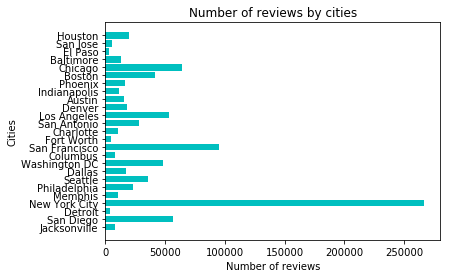

In [15]:
#Total number of cities or regions?
print("Total number of regions ids: ", len(set(all_df.hotel_region_id.values)))
print("Total number of regions names: ", len(set(all_df.hotel_address_region.values)))
print("Region names : ", set(all_df.hotel_address_region.values))
print("Total number of postal Codes: ", len(set(all_df.hotel_address_postal_code.values)))
print("Total number of hotel localities: ", len(set(all_df.hotel_address_locality.values)))
print("Locality names : ", set(all_df.hotel_address_locality.values))

#plot bar chart of different number of reviews in different localities
localities = list(set(all_df.hotel_address_locality.values))
num_reviews = []
for locality in localities:
    num_reviews.append(len(all_df[all_df.hotel_address_locality == locality].values))

print(num_reviews)
plt.barh(localities, num_reviews, color=random_color())
plt.xlabel("Number of reviews")
plt.ylabel("Cities")
plt.title("Number of reviews by cities")
#Perhaps we can plot some sort of a correlation heat map between regions/cities

In [16]:
#Total number of users
print("Number of distinct author ids: ", len(set(all_df.author_id.values)))
print("Number of distinct usernames: ", len(set(all_df.author_username.values)))
#Why is the number of author ids and usernames different? Some noise?

Number of distinct author ids:  576689
Number of distinct usernames:  536952


In [17]:
#Total number of languages present
#make another column in dataframe which tells us the language of the review
# languages = []
# for i in tqdm(range(len(all_df))):
#     try:
#         lang = detect(all_df.iloc[i].text)
#         languages.append(lang)
#     except:
#         languages.append(np.nan)
# all_df['language'] = languages
print("Number of languages in reviews: ", len(set(all_df.language.values)))

Number of languages in reviews:  33


In [18]:
# localities = list(set(all_df.hotel_address_locality.values))
# num_reviews = []
# for locality in localities:
#     num_reviews.append(len(all_df[all_df.hotel_address_locality == locality].values))

# # print(num_reviews)
# plt.barh(localities, num_reviews)
all_df.groupby('language').review_id.nunique()

language
NA            2
af           22
ar            1
ca           10
da         1667
de        27061
el           20
en       771064
es        14169
fi            1
fr        24996
hr            1
hu            1
id            5
it        20325
ja         6013
ko           37
lv            1
nl         3262
no         1388
pl           51
pt         4526
ro            3
ru          281
sl            1
so            7
sq            1
sv         2977
th           15
tr          110
vi            5
zh-cn       527
zh-tw        11
Name: review_id, dtype: int64

Number of reviews in english:  771064
['english', 'others']
[771064, 107497]


Text(0.5, 1.0, 'Number of reviews in English vs Number of reviews in other languages')

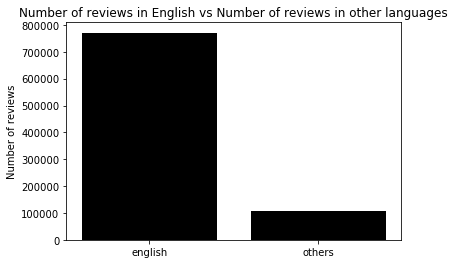

In [19]:
#How many reviews per language present
languages = list(set(all_df.language.values))
num_reviews_others = []
num_reviews_english = None
for lang in languages:
    n = len(all_df[all_df.language == lang].values) #may not detect nan values
    if lang == "en":
        num_reviews_english = n
        print("Number of reviews in english: ", n)
    else:
        num_reviews_others.append(n)

#Plot english vs others bar chart
x = ['english', 'others']
y = [num_reviews_english, sum(num_reviews_others)]
print(x)
print(y)
plt.bar(x,y, color=random_color())
plt.ylabel("Number of reviews")
plt.title("Number of reviews in English vs Number of reviews in other languages")

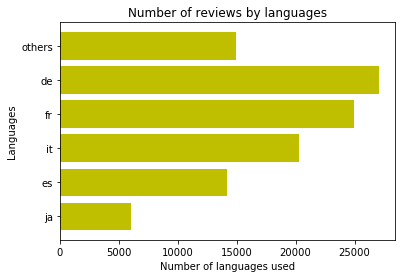

In [20]:
from functools import reduce
#Plot the bar chart of top 10 languages besides english
try: languages.remove("en")
except: pass
assert(len(languages) == len(num_reviews_others))

#sort the lists in descending order according to the number of reviews
num_reviews_others, languages = sort_two_lists(num_reviews_others, languages)

#Group the ones below 5000 automatically
SUM = reduce(lambda x,y: x+y, [i for i in num_reviews_others if i<5000])
#filter lists
num_reviews_others, languages = filter_two_lists(num_reviews_others, languages, lambda x: x>=5000)
num_reviews_others.append(SUM)
languages.append("others")
plt.barh(languages,num_reviews_others, color=random_color())
plt.xlabel("Number of languages used")
plt.ylabel("Languages")
plt.title("Number of reviews by languages")
plt.show()

In [21]:
def tokenize_reviews_in_words(df):
    tokens = []
    reviews = df.text.values
    tokenize_func = tokenize_in_words
    for r in tqdm(reviews):
        tokens.append(tokenize_func(r.lower()))
    return pd.Series(data=tokens, index = df.index)

#test
parallelize_dataframe(all_df.sample(100), tokenize_reviews_in_words)

100%|██████████| 25/25 [00:00<00:00, 551.21it/s]


212067    [pros, big, rooms, well, furnished, clean, nic...
49936     [i, was, kind, of, nervous, to, see, what, the...
572322    [this, time, we, stayed, 4, days, at, the, que...
543235    [our, initial, impression, of, this, hotel, wa...
219724    [my, daughter, and, i, stayed, at, the, plaza,...
493287    [a, very, charming, motel, that, is, very, ver...
183861    [le, meilleur, lit, où, j'ai, dormi, de, ma, v...
107045    [2009年の10月に一人で宿泊しました。, 場所は地下鉄86stの駅から徒歩3分位でアッパ...
814237    [i, had, out, of, town, guests, in, the, summe...
630544    [you, 're, in, the, middle, of, it, all, near,...
743782    [i, have, stayed, at, various, kimpton, hotels...
251370    [amazing, hotel, right, in, the, middle, of, t...
107113    [le, responsable, de, l'hôtel, n, a, pas, de, ...
565705    [the, room, was, very, very, small, and, drear...
772931    [the, location, of, this, hotel, is, unbeatabl...
877181    [a, great, week-end, provided, by, the, hotel,...
697351    [i, checked, into, the, marrio

In [22]:
words_series = parallelize_dataframe(all_df, tokenize_reviews_in_words, n_cores=8)
all_df["num_words"] = words_series.apply(lambda x: len(x))

100%|██████████| 109820/109820 [04:58<00:00, 368.48it/s]

['en' 'de' 'fr' 'it' 'es']


Text(0.5, 0, 'Avg. Number of words per review')

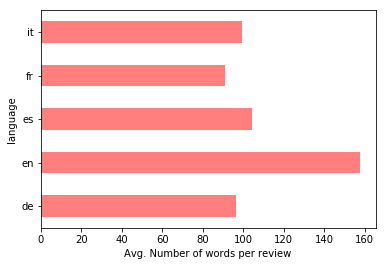

In [25]:
top_5_lang = all_df.groupby('language').language.count().sort_values(ascending=False).head(5).index.values #
print(top_5_lang)
all_df[all_df.language.isin(top_5_lang)].groupby('language').num_words.mean().plot(kind='barh', alpha=0.5, color= random_color())
plt.xlabel("Avg. Number of words per review")

In [26]:
def tokenize_reviews_in_sentences(df):
    tokens = []
    reviews = df.text.values
    tokenize_func = tokenize_in_sentences
    for r in tqdm(reviews):
        tokens.append(tokenize_func(r.lower()))
    return pd.Series(data=tokens, index = df.index)

#test
parallelize_dataframe(all_df.sample(100), tokenize_reviews_in_sentences).head(5)

100%|██████████| 25/25 [00:00<00:00, 3967.52it/s]

100%|██████████| 25/25 [00:00<00:00, 2504.96it/s]


450608    [the hotel is within 15mins from the airport a...
786132    [we loved this hotel!, the location was incred...
381734    [the hotel is located in brentwood, bel air ar...
283541    [room was not as featured on website., too sma...
521330    [stayed here for a week., an older building bu...
dtype: object

In [27]:
sent_series = parallelize_dataframe(all_df, tokenize_reviews_in_sentences, n_cores=8)
all_df["num_sent"] = sent_series.apply(lambda x: len(x))

100%|██████████| 109820/109820 [01:00<00:00, 1800.57it/s]


Text(0.5, 0, 'Avg. Number of sentences per review')

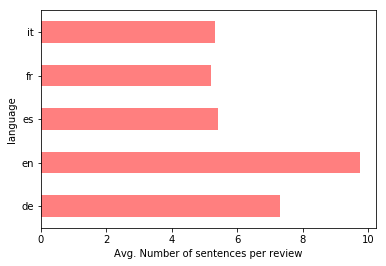

In [29]:
all_df[all_df.language.isin(top_5_lang)].groupby('language').num_sent.mean().plot(kind='barh', alpha=0.5, color= random_color())
plt.xlabel("Avg. Number of sentences per review")

In [30]:
#Japanese doesn't have spaces so it may not tokenize well because it doesn't have spaces between words. 
#Also NLTK tokenizer only works best for english and english like languages.
#Unfortunately, at least for now, we have to make our analysis language specific. 

Text(0.5, 1.0, 'Number of reviews per aspect')

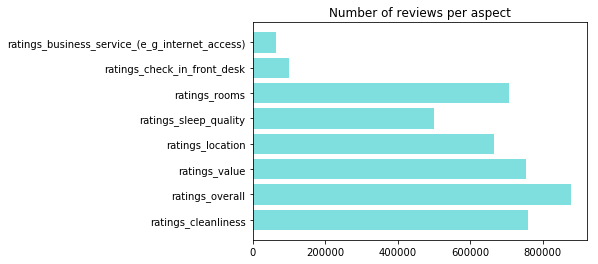

In [31]:
#How many times different aspects ocur in reviews?
aspects = ['ratings_cleanliness', 'ratings_overall', 'ratings_value',
       'ratings_location', 'ratings_sleep_quality', 'ratings_rooms',
       'ratings_check_in_front_desk', 'ratings_business_service_(e_g_internet_access)']
num_reviews = []
for aspect in aspects:
    n = len(all_df[aspect].dropna().values)
    num_reviews.append(n)

plt.barh(aspects, num_reviews, color=random_color(), alpha=0.5)
plt.title("Number of reviews per aspect")

In [32]:
#Why is it different?-> because tokenizers are different.

In [5]:
#from here on, only english
all_df = all_df[all_df.language=='en'].drop('language', axis=1)
# all_df.columns

Longest and shortest reviews have these many words:  655 17


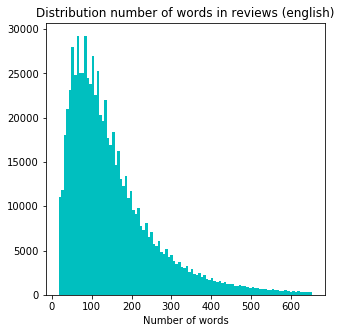

In [34]:
def plot_distributions(distributions, columns, title=""):
    assert(len(distributions) == len(columns))
    fig, axs = plt.subplots(1,len(columns), figsize=(5*len(columns), 5))
    for i in range(len(columns)):
        if len(columns) > 1:
            axs[i].hist(distributions[i], bins=100, color = random_color())
            axs[i].set_xlabel("Number of words")
            axs[i].set_title(columns[i])
        else:
            axs.hist(distributions[i], bins=100, color = random_color())
            axs.set_xlabel("Number of words")
            axs.set_title(columns[i])
    fig.suptitle(title)
#     fig.show()
    
# #Length distribution of reviews
# review_lengths = []
# for review in tqdm(test_df[test_df.language == 'en'].text.values):
#     review_lengths.append(len(tokenize_in_words(review.lower()))) #

review_lengths = filter_by_quantiles(all_df['num_words'].values, [0.01, 0.99])
plot_distributions([review_lengths], ["Distribution number of words in reviews (english)"])
#How to normalize this distribution?
#Longest review?
print("Longest and shortest reviews have these many words: ", max(review_lengths), min(review_lengths))
#Outliers?

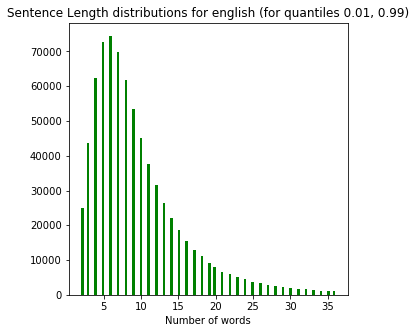

In [35]:
#plot distribution of num of sentences
sentence_lengths = filter_by_quantiles(all_df['num_sent'], [0.01, 0.99])
plot_distributions([sentence_lengths], ["Sentence Length distributions for english (for quantiles 0.01, 0.99)"])

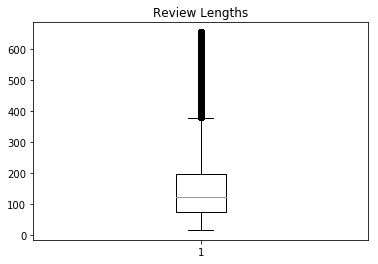

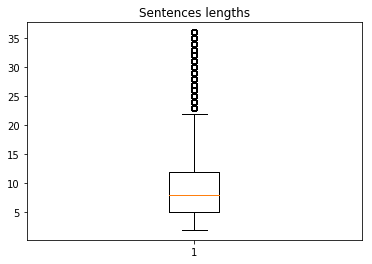

In [36]:
#Study the outliers -> box plot
plt.boxplot(review_lengths)
plt.title("Review Lengths")
plt.show()
plt.boxplot(sentence_lengths)
plt.title("Sentences lengths")
plt.show()
#Why is the knowing the sentence lengths important? -> Because language models are sensitive to input lengths. 

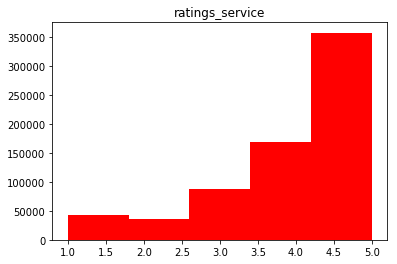

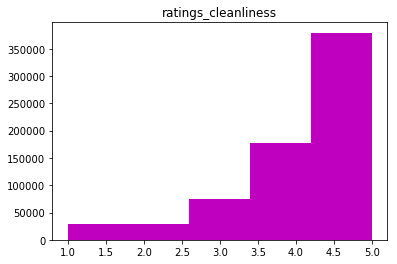

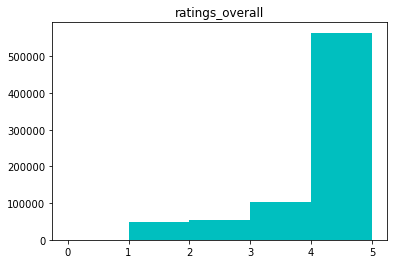

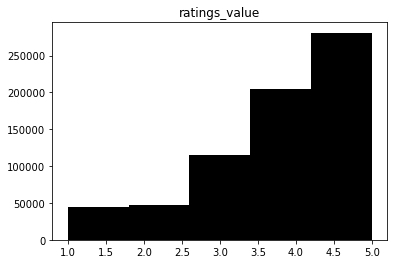

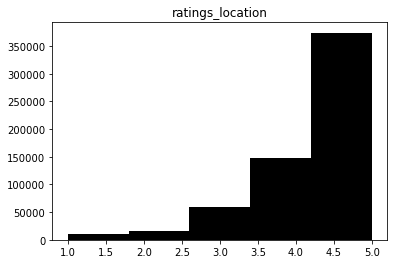

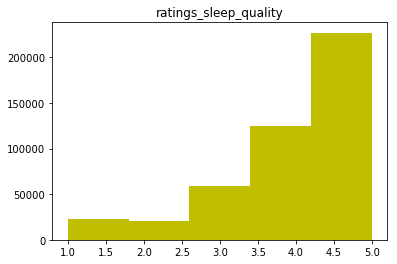

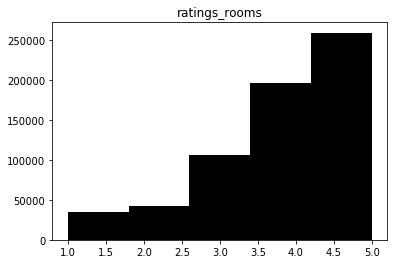

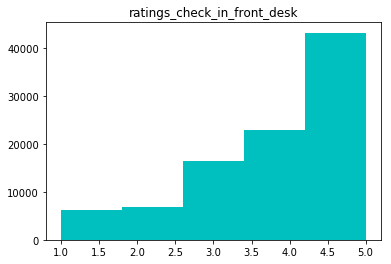

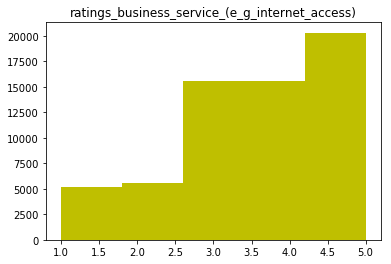

In [37]:
#plot review distributions
def plot_sentiment_distributions(df):
    columns = [col for col in df.columns if "rating" in col]
#     fig, ax = plt.subplots(len(columns), 1, figsize=(30,50))
    for i in range(len(columns)):
        X = df[columns[i]].values
        plt.hist(X, color=random_color(), bins=5) #ax[i]
        plt.title(columns[i]) #
        plt.show()
#     fig.show()
plot_sentiment_distributions(all_df)

In [3]:
text = word_tokenize("That was and not good a good hotel. THe staff wasn't bad. Neither it was good, nor it was worse")
nltk.pos_tag(text)

[('That', 'DT'),
 ('was', 'VBD'),
 ('and', 'CC'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('hotel', 'NN'),
 ('.', '.'),
 ('THe', 'JJ'),
 ('staff', 'NN'),
 ('was', 'VBD'),
 ("n't", 'RB'),
 ('bad', 'JJ'),
 ('.', '.'),
 ('Neither', 'CC'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('good', 'JJ'),
 (',', ','),
 ('nor', 'CC'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('worse', 'JJR')]

In [39]:
# def remove_stopwords(text):
#     """wrapper using the nltk stopwords but not treating negation words as stopwords"""
#     stopwords = nltk.corpus.stopwords.words("english")
#     negation_words = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', "couldn't", \
#                       'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", \
#                       'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', \
#                       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", \
#                       'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
#     stopwords = [word for word in stopwords if word not in negation_words]
#     #use regex to remove stop words
#     for word in stopwords:
#         pass
#         #if the word is either beginning or surrounded by space
        


# #Test the above function
# remove_stopwords("Hitler had a tiny moustache. Hence, He was the fuhrer")

In [82]:
def display_word_cloud(texts, columns, title=""):
    #change the following code to plot the word cloud for different cities
    
    assert(len(texts) == len(columns))
    assert(len(columns) > 0)
    fig, ax = plt.subplots(1, len(columns), figsize = (4*len(columns), 4))
    fig.suptitle(title)
    for i in range(len(columns)):
        text = texts[i]
        wc = wordcloud.WordCloud(width = 500, height=500, background_color="white", stopwords=[]).generate(text) #
        if len(columns) > 1:
            ax[i].imshow(wc, interpolation="bilinear", aspect='auto')
            ax[i].set_title(columns[i])
        else:
            ax.imshow(wc, interpolation="bilinear", aspect='auto')
            ax.set_title(columns[i])
    fig.show()

In [83]:
def sentiment_words(df):
    sentiment_words = " "
    
    #filter only the words which are responsible for sentiment: JJ, JJR, JJS, RBR, RBS
    sentiment_tags = ['JJ','JJR','JJS', 'RBR' ,'RBS'] # ,'RB','VB', 'VBD', 'VBG', 'VBN' ,'VBP','VBZ'
    sentiment_words = []
    for i in tqdm(range(len(df))):
        tokens = tokenize_in_words(df.iloc[i].text)
        tokens_with_pos = pos_tag(tokens)
        tokens_with_pos = [tpl for tpl in tokens_with_pos if tpl[1] in sentiment_tags]
        tokens_sentiments_only = [tpl[0].lower() for tpl in tokens_with_pos]
        sentiment_words.append(" ".join(tokens_sentiments_only))
    df["sentiment_text"] = sentiment_words
    return df
#test
# sentiment_words(all_df[:5])

In [91]:
sentiment_df = parallelize_dataframe(all_df.sample(10000), sentiment_words, n_cores=8)
# sentiment_df.to_csv("./sentiment_df.csv")
# sentiment_df = pd.read_csv("./sentiment_df.csv").drop("Unnamed: 0", axis=1)
# sentiment_df = sentiment_df[sentiment_df.language == "en"]

100%|██████████| 1250/1250 [00:17<00:00, 72.26it/s] 


Joining all text...
Displaying the word cloud...


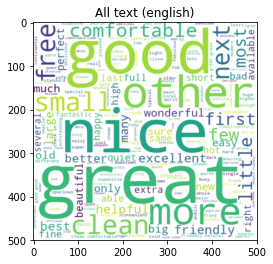

In [92]:
print("Joining all text...")
sentiment_text = " ".join(sentiment_df.sentiment_text.values)
print("Displaying the word cloud...")
display_word_cloud([sentiment_text],['All text (english)'])

In [12]:
sentiment_df.sentiment_text.sample(10)

12028     is pleasant enough and are friendly but 's def...
574488    same other central nice safe and also transpor...
633891    yes is oldest most beautiful 've ever seen but...
208613    di tour una ancora alloggiato sulla ultimi una...
103283    stayed catching booked got decent but found la...
52099     is superb great nice club and fantastic was bo...
218308    caracteriza una para hacerte una mucha varieda...
135022    has convenient and get considering is and is n...
329241    old is kinder and more helpful then also shows...
632416    is old and are small but have needed best is a...
Name: sentiment_text, dtype: object

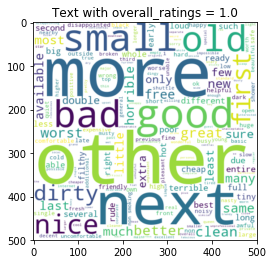

In [93]:
#Word cloud with rating 1.0
rating = 1.0
_text = sentiment_df[sentiment_df.ratings_overall == rating].sentiment_text.values
# print(_text)
text = " "
for t in _text:
    try:
        text += t
        text += " "
    except:
        pass
# print(text)
display_word_cloud([text], ['Text with overall_ratings = '+str(rating)])

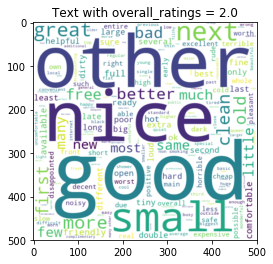

In [94]:
#Word cloud with rating 2.0
rating = 2.0
text = sentiment_df[sentiment_df.ratings_overall == rating].sentiment_text.values
text = " ".join(text)
display_word_cloud([text], ['Text with overall_ratings = '+str(rating)])

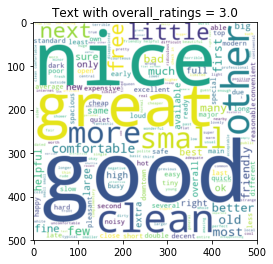

In [95]:
#Word cloud with rating 3.0
rating = 3.0
text = sentiment_df[sentiment_df.ratings_overall == rating].sentiment_text.values
text = " ".join(text)
display_word_cloud([text], ['Text with overall_ratings = '+str(rating)])

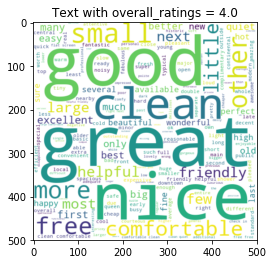

In [96]:
#Word cloud with rating 4.0
rating = 4.0
text = sentiment_df[sentiment_df.ratings_overall == rating].sentiment_text.values
text = " ".join(text)
display_word_cloud([text], ['Text with overall_ratings = '+str(rating)])

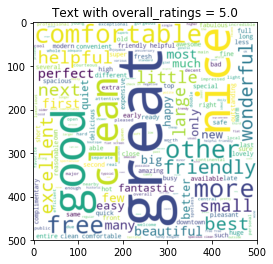

In [97]:
#Word cloud with rating 5.0
rating = 5.0
text = sentiment_df[sentiment_df.ratings_overall == rating].sentiment_text.values
text = " ".join(text)
display_word_cloud([text], ['Text with overall_ratings = '+str(rating)])

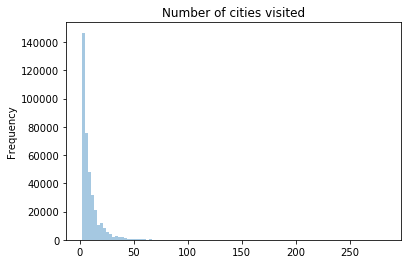

In [25]:
#plot the user stats
#Number of cities visited
user_cols = ['author_username', 'author_num_cities', 'author_location',\
            'author_num_helpful_votes', 'author_num_reviews', 'author_num_type_reviews', 'author_id']
#use mean here because of duplicate records
all_df.groupby("author_username")['author_num_cities'].mean()\
                            .plot(kind='hist', alpha=0.4, title="Number of cities visited", bins=100)

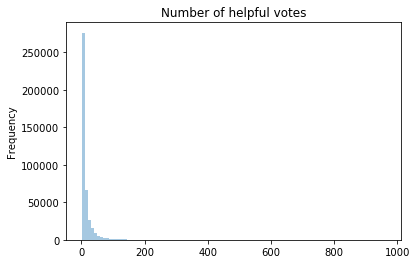

In [27]:
#Number of helpful votes 
#we use mean here because of duplicate records
all_df.groupby("author_username")['author_num_helpful_votes'].mean()\
                            .plot(kind='hist', alpha=0.4, title="Number of helpful votes", bins=100)

In [ ]:
#Correlation b/w num of helpful votes per review and num of cities visited
q1 = "SELECT author_id, AVG(author_num_cities), AVG(author_num_helpful_votes)/COUNT(author_id)\
        GROUP BY author_id"

result = test_df.groupby("author_username")[['author_num_cities', 'author_num_helpful_votes']].mean().dropna() #.sort_values(ascending=False, by='author_num_cities')
result['author_num_helpful_votes'] = result['author_num_helpful_votes']\
                                        .divide(test_df.groupby("author_username")["author_username"].count())\
                                        .sort_values()#by='author_num_cities')
result
# result.plot(x='author_num_cities', y='author_num_helpful_votes', kind="scatter")
test_df.groupby("author_username")["author_username"].count()


In [ ]:
#plot user locations

In [ ]:
#which is more reliable: username or author_id?

In [ ]:
"""Metrics
1. Sentiment Distributions 
2. Word Cloud 
3. Number of Words in Reviews
4. Number of sentences in Reviews
5. Outlier Distributions
Dont remove all the negation words!!
"""

In [ ]:
"""List traveller's profile:
1. Top 5 countries nationalities with the percent
2. Traveler profile percent
3. Instagram Followers???

Here are traveller profiles:
Family/Families
Couples
Friends/Group of Friends
Solo/Solo Travelers
Business/Business Travelers
"""
len(test_df.author_location.unique())

In [ ]:
#print different dates used
# _ = plt.hist()
len(test_df.date.unique())

In [74]:
reviews = sentiment_df.text.values[:10000]
ratings = sentiment_df.ratings_overall.values[:10000]

In [75]:
from textblob import TextBlob

In [76]:
sentiments = []
for r in tqdm(reviews):
    sentiments.append(\
                    TextBlob(r).sentiment.polarity)

100%|██████████| 10000/10000 [00:08<00:00, 1123.70it/s]


In [77]:
sentiments[:10]

[0.27687074829931974,
 0.31580578512396695,
 0.3019927536231884,
 0.23166971916971918,
 0.3172453703703704,
 0.18874999999999997,
 0.4777225378787879,
 0.3608620509607352,
 0.325,
 0.3068979266347688]

In [78]:
#scale values
min_x = -1.0
max_x = 1.0
a = 1.0
b = 5.0
# _sentiments = sentiments.copy()
for i in range(len(sentiments)):
    x_i = sentiments[i] #.polarity
    z_i = ((b-a)*(x_i - min_x)/(max_x - min_x)) + a
    sentiments[i] = float(round(z_i))

In [79]:
sentiments[:10]

[4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0]

Text(0, 0.5, 'Sentiment Scores')

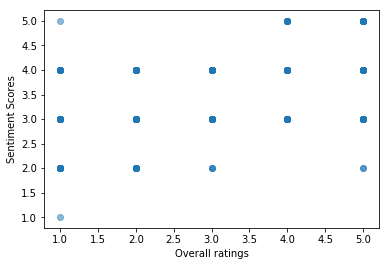

In [80]:
plt.scatter(ratings, sentiments, alpha=0.5)
plt.xlabel("Overall ratings")
plt.ylabel("Sentiment Scores")

In [81]:
# !pip install sklearn
from sklearn.metrics import accuracy_score
accuracy_score(ratings, sentiments)

0.2273

In [102]:
all_df.date.sort_values().values

array(['April 1, 2002', 'April 1, 2002', 'April 1, 2002', ...,
       'September 9, 2012', 'September 9, 2012', 'September 9, 2012'],
      dtype=object)

In [ ]:
#Plot sentiment distributions for NY, Chicago and San Francisco

In [ ]:
#Plot sentiment distributions for different languages (English, French and German)

In [ ]:
#Plot review length distribution for different cities (english)

In [ ]:
#Plot box plot for different cities

In [ ]:
#Plot word cloud distribution for different cities (english)

In [ ]:
#Are above metrics different for different languages?

In [ ]:
#Are different columns standardised?

In [ ]:
#Deal with NaN values

In [ ]:
#Colloquilisms and Spelling errors

In [ ]:
#Is there any inductive bias in the text?

In [ ]:
#How do distributions change when the ratings of the reviewer increases?

In [ ]:
#How do distributions change with the hotel class? (5 star, 4 star, etc.)

In [ ]:
#Are above metrics different for users from different cities?
#-> I dont think this really matters right now. 

In [ ]:
"""
Find a way to compare text distributions. 
Plot a heatmap of distribution comparisons in different regions of hotels and reviewers resp. Also we can do same for different languages.
"""